In [ ]:
from animalclef.spark import get_spark

spark = get_spark(memory="1g")

25/05/12 20:05:40 WARN Utils: Your hostname, hawksbill-vm resolves to a loopback address: 127.0.1.1; using 192.168.10.12 instead (on interface ens18)
25/05/12 20:05:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 20:05:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/12 20:05:40 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


25/05/12 20:05:52 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [2]:
from pathlib import Path
from pyspark.sql import functions as F

root = Path("~/scratch/animalclef").expanduser()

# split 0.6 train, 0.5 val/test, 0.8 known/unknown
df = (
    spark.read.json(
        f"{root}/processed/submissions/*/*/test_best_threshold.json", multiLine=True
    )
    .withColumn("filename", F.input_file_name())
    .withColumn(
        "model", F.udf(lambda p: Path(p).parts[-3], "string")(F.col("filename"))
    )
    .withColumn(
        "epoch", F.udf(lambda p: Path(p).parts[-2], "string")(F.col("filename"))
    )
    .drop("filename")
)
df.show(n=2, vertical=True)

-RECORD 0-------------------------------
 baks            | 0.0978163460221459   
 baus            | 0.4030279662962944   
 crossover_score | 0.6947883797258515   
 mad             | 0.013598615303635597 
 median          | 0.028750751167535782 
 num_neighbors   | 1.0                  
 score           | 0.19855156259229007  
 threshold       | 0.020202020202020332 
 model           | dino-random          
 epoch           | head_epoch=020       
-RECORD 1-------------------------------
 baks            | 0.09003787021637635  
 baus            | 0.4396936054349951   
 crossover_score | 0.6503442647813813   
 mad             | 0.013382175005972385 
 median          | 0.027000820264220238 
 num_neighbors   | 1.0                  
 score           | 0.1989700373953995   
 threshold       | -0.08080808080808088 
 model           | dino-random          
 epoch           | head_epoch=040       
only showing top 2 rows



In [3]:
df.select("model", "epoch", "score").orderBy(F.desc("score")).show(n=10)
df.select("model", "epoch", "score").orderBy(F.asc("score")).show(n=10)

+-----------------+--------------+------------------+
|            model|         epoch|             score|
+-----------------+--------------+------------------+
|dino-semihard-mrl|head_epoch=090|0.6657138514111686|
|    dino-semihard|head_epoch=080|0.6644477654867688|
|    dino-semihard|          head|0.6632266688719101|
|    dino-semihard|head_epoch=070|0.6603035222395245|
|dino-semihard-mrl|head_epoch=040|0.6578217545150697|
|dino-semihard-mrl|head_epoch=030|0.6568864280682662|
|    dino-semihard|head_epoch=040|0.6542560211582941|
|    dino-semihard|head_epoch=030|0.6522566722946329|
|dino-semihard-mrl|head_epoch=080|0.6511822424395838|
|dino-semihard-mrl|          head| 0.650892109810232|
+-----------------+--------------+------------------+
only showing top 10 rows

+-----------+--------------+-------------------+
|      model|         epoch|              score|
+-----------+--------------+-------------------+
|dino-random|head_epoch=090|0.19377740586094627|
|dino-random|         

Text(0.5, 1.0, 'DINO triplet score over epoch')

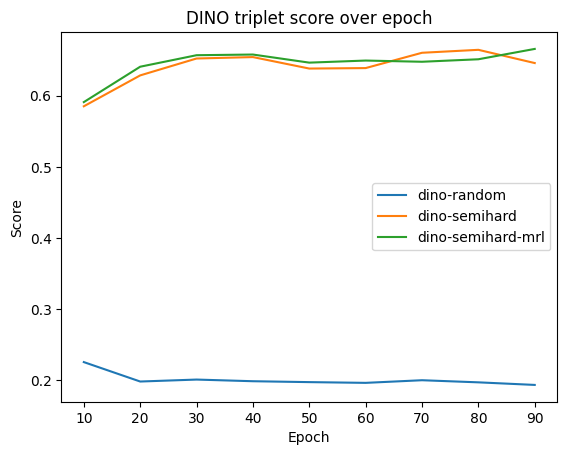

In [4]:
from matplotlib import pyplot as plt

for row in df.select("model").distinct().collect():
    pdf = (
        df.where(f"model = '{row.model}' and epoch like '%=%'")
        .orderBy("epoch")
        .toPandas()
    )

    plt.plot(
        pdf["epoch"].str.split("=", expand=True)[1].astype(int),
        pdf["score"],
        label=row.model,
    )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("DINO triplet score over epoch")